In [1]:
from conf import databases, url, data_dir

In [2]:
import wfdb
import numpy
import json
import os
import glob
import random

In [91]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, MaxPooling1D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard, LambdaCallback, ModelCheckpoint
from matplotlib import pyplot as plt
import matplotlib as mpl

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [ ]:
for db, ids in databases:
    for i in ids:
        f = data_dir + db + '/' + i
        if os.path.isfile(f + '.dnn.npz'):
            continue
        print(f, end='')
        sig, fields = wfdb.srdsamp(f)
        ann = wfdb.rdann(f, 'atr')
        if not numpy.array_equal(ann.chan, numpy.full(len(ann.chan), ann.chan[0])):
            print(' Not good...')
            continue
        x = sig[:, ann.chan[0]]
        y = numpy.zeros(len(x))
        for v in ann.annsamp:
            y[v] = 1
        numpy.savez_compressed(f + '.dnn.npz', numpy.asarray([x, y]))
        print()

In [51]:
# NN params
segment_size = 5000
segment_step = 2500
y_delay = 5

train_perc = 90
test_perc = 100 - train_perc

In [52]:
def load_fnpz(filepath):
    xy = numpy.load(f, mmap_mode='r', allow_pickle=True)['arr_0']
    return xy[0,:], xy[1,:]

# Load data
sigs = []
for f in glob.glob(data_dir + 'mitdb/*.dnn.npz'):
    x, y = load_fnpz(f)
    sigs.append((x, y))

XY = []
for (x, y) in sigs:
    for i in range(0, len(x)+1-segment_size, segment_step):
        # We pad y labels with *y_delay* zeros (so that RNN has some future context to predict classes)
        XY.append((
            [[e] for e in x[i:i+segment_size]],
            numpy.concatenate(([[0] for e in range(y_delay)], [[e] for e in y[i:i+segment_size-y_delay]]))[:segment_size]
        ))
random.shuffle(XY)
print('Constructed {} examples of length {} with a delay of {} sample(s).'.format(len(XY), segment_size, y_delay))

s = int(len(XY) * train_perc/100)
trainXY, testXY = XY[:s], XY[s:]

print('- {} training examples ({}%)'.format(len(trainXY), train_perc))
print('- {} training examples ({}%)'.format(len(testXY), test_perc))
trainXY = numpy.asarray(trainXY)
testXY = numpy.asarray(testXY)

Constructed 12432 examples of length 5000 with a delay of 5 sample(s).
- 11188 training examples (90%)
- 1244 training examples (10%)


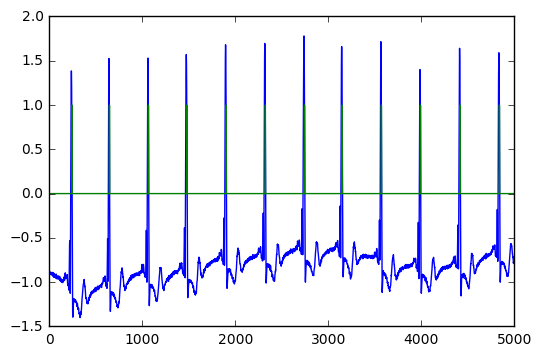

In [53]:
plt.plot(trainXY[1,0])
plt.plot(trainXY[1,1])
plt.show()

In [54]:
print(trainXY.shape[0])
print(testXY.shape)
unique_items, counts = numpy.unique(trainXY[:,1], return_counts=True)
ratio_zero_one = counts[0]/counts[1]
print(ratio_zero_one)

11188
(1244, 2, 5000, 1)
276.485664398


In [96]:
from keras import backend as K
from theano.tensor import basic as tensor
_EPSILON = 10e-8
import tensorflow as tf
from keras.backend.tensorflow_backend import _to_tensor
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops as mo
from tensorflow.python.ops import nn_ops
from sklearn.metrics import f1_score

def my_loss(targets, logits, name=None):
    with ops.name_scope(name, "logistic_loss", [logits, targets]) as name:
        logits = ops.convert_to_tensor(logits, name="logits")
        targets = ops.convert_to_tensor(targets, name="targets")
        try:
            targets.get_shape().merge_with(logits.get_shape())
        except ValueError:
            raise ValueError("logits and targets must have the same shape (%s vs %s)"
                           % (logits.get_shape(), targets.get_shape()))
        #return math_ops.add(ratio_zero_one*(1-logits)*targets, (1-targets)*logits, name=name)
        loss_tp = mo.abs(mo.log(mo.div(
                    mo.reduce_sum(mo.multiply(targets, logits)),
                    mo.reduce_sum(targets))))
        loss_tn = mo.abs(mo.log(mo.div(
                    mo.reduce_sum(mo.multiply((1-targets), (1-logits))),
                    mo.reduce_sum((1-targets)))))
        return math_ops.add(loss_tp, loss_tn)


def rpeaks(y_true, y_pred):
    return K.sum(y_pred)/K.sum(y_true)

try:
    del model
except NameError:
    pass

model1 = Sequential()
model1.add(LSTM(units=512, input_shape=(segment_size, 1), return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss=my_loss, optimizer='adam', metrics=['accuracy', Rpeaks_metric])


model2 = Sequential()
model2.add(LSTM(units=1024, input_shape=(segment_size, 1), return_sequences=True))
model2.add(Dense(100))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss=my_loss, optimizer='adam', metrics=['accuracy', Rpeaks_metric])


# SVG(model_to_dot(model).create(prog='dot', format='svg'))

INFO:tensorflow:Summary name lstm_23/kernel:0 is illegal; using lstm_23/kernel_0 instead.
INFO:tensorflow:Summary name lstm_23/kernel:0 is illegal; using lstm_23/kernel_0 instead.
INFO:tensorflow:Summary name lstm_23/recurrent_kernel:0 is illegal; using lstm_23/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_23/recurrent_kernel:0 is illegal; using lstm_23/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_23/bias:0 is illegal; using lstm_23/bias_0 instead.
INFO:tensorflow:Summary name lstm_23/bias:0 is illegal; using lstm_23/bias_0 instead.
INFO:tensorflow:Summary name dense_39/kernel:0 is illegal; using dense_39/kernel_0 instead.
INFO:tensorflow:Summary name dense_39/kernel:0 is illegal; using dense_39/kernel_0 instead.
INFO:tensorflow:Summary name dense_39/bias:0 is illegal; using dense_39/bias_0 instead.
INFO:tensorflow:Summary name dense_39/bias:0 is illegal; using dense_39/bias_0 instead.
INFO:tensorflow:Summary name dense_40/kernel:0 is illegal; using den

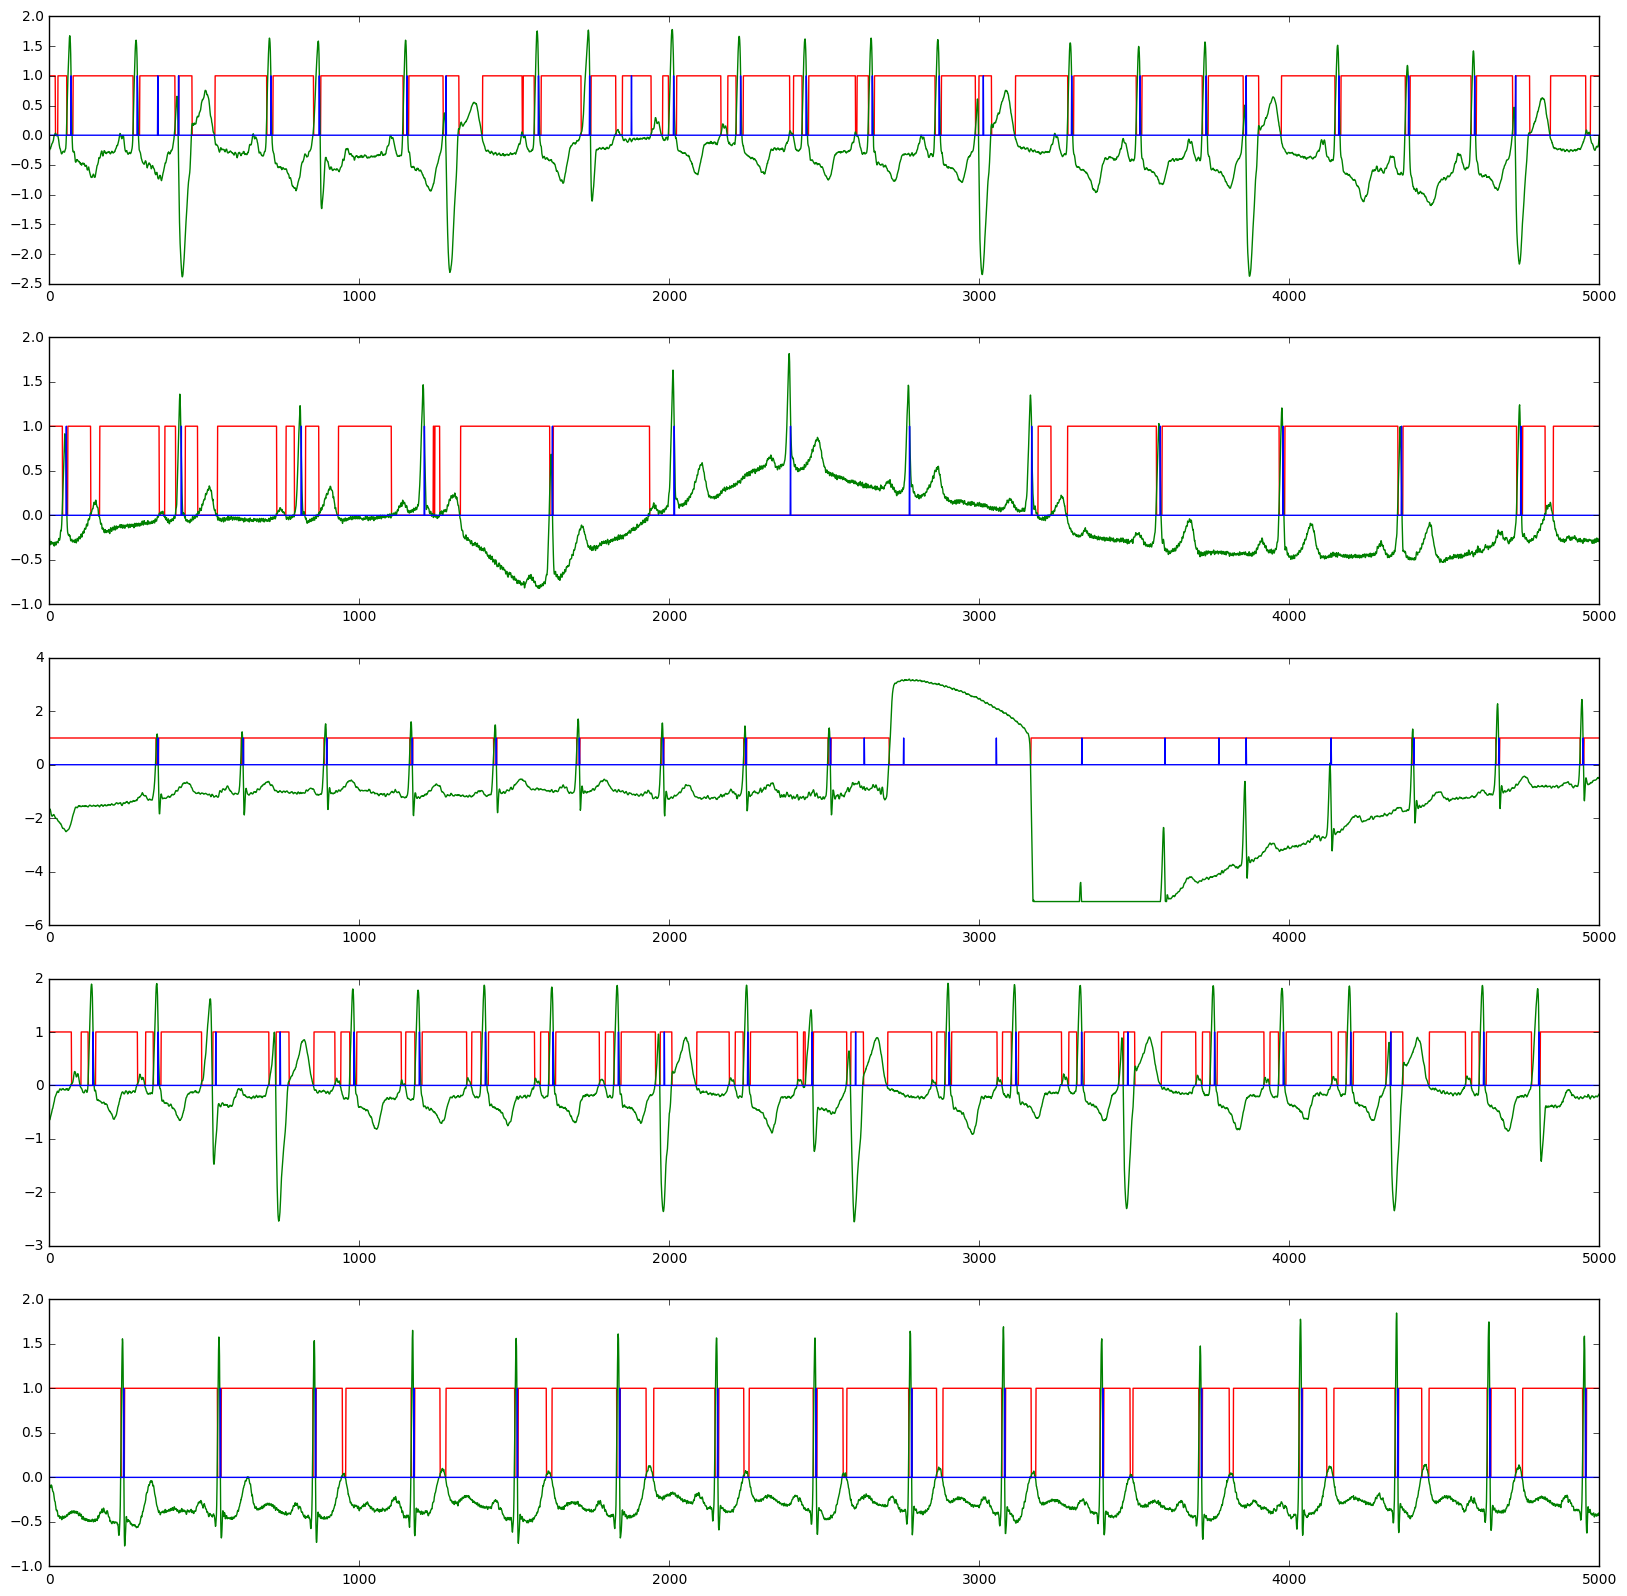

Epoch 1/10
36/50 [====================>.........] - ETA: 197s - loss: 0.9245 - acc: 0.8170 - Rpeaks_metric: 97.8853

In [ ]:
model = model2

samples_used = 0
def gen_samples(XY):
    while True:
        for i in range(XY.shape[0]):
            # samples_used += 
            yield (numpy.asarray([XY[i,0]]), numpy.asarray([XY[i,1]]))
            

def plot_callback(epoch):
    exs = [0, 42, 56, 60, 65]
    fig, ax = plt.subplots(len(exs), figsize=(20, 20))
    for i in range(len(exs)):
        ex_id = exs[i]
        res = [e[0] for e in model.predict_classes(testXY[ex_id]).tolist()[0]]
        ax[i].plot(res, color='red')
        ax[i].plot(testXY[ex_id, 0], color='green')
        ax[i].plot(testXY[ex_id, 1], color='blue')
    plt.show()


tbCallBack = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)
plotClbk = LambdaCallback(on_epoch_begin=lambda epoch, logs: plot_callback(epoch))
ckpt = ModelCheckpoint('logs/weights.{epoch:02d}-{loss:.2f}-{acc:.2f}.hdf5', monitor='loss', verbose=1)

history = model.fit_generator(gen_samples(trainXY),
                              steps_per_epoch=50,
                              epochs=10,
                              verbose=1,
                              callbacks=[tbCallBack, plotClbk, ckpt])

In [61]:
model1.load_weights('logs/delay5-lstm512-dense1/weights.01-0.67-0.91.hdf5')